# Modeling with StatsModels

## 1. Ordinary Least Square
- Column Names
- Log Transformation
- Condition Number
- Standard Scaling

# 2. Dimensionality Reduction
- ANOVA
- F-test and Feature Influence

# 3. Outlier
- Cook's Distance

# 4. Regularization
- Lasso

# 5. Diagnosis of Regression
- Residual Normality Test
- Partial Regression Plot

# 6. Cross Validatoin

# 7. Test
- score

In [1]:
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import warnings
import sys
import datetime
import scipy as sp
import statsmodels.stats.api as sms
import statsmodels.api as sm
from patsy import dmatrix
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import utils.statsmodel_helper as sh
import utils.feature_selection as fs
import utils.preprocessing as pp
import utils.error_calculator as ec

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

df_train_macro = pd.read_csv('../code/data/train_macro3.csv', index_col=0)
df_test_macro = pd.read_csv('../code/data/test_macro3.csv', index_col=0)

sys.setrecursionlimit(1500)

degree = 2
skewness_limit = 1
num_of_cooks = 2
num_of_f_test = 10

# 1. Column Names
## Column Names
Replace -, +, :, ~, * in column name with underscore

In [2]:
new_cols = []
for col in  list(df_train_macro.columns):
    col = col.replace('-', '_').replace('+', '_').replace(':', '_').replace('~', '_').replace('*', '_')
    new_cols.append('_'+col)
df_train_macro.columns = new_cols

new_cols = []
for col in list(df_test_macro.columns):
    col = col.replace('-', '_').replace('+', '_').replace(':', '_').replace('~', '_').replace('*', '_')
    new_cols.append('_'+col)
df_test_macro.columns = new_cols

categorial_ivs = list(set(df_train_macro.columns) - set(df_train_macro._get_numeric_data().columns))
numeric_ivs = df_train_macro._get_numeric_data().columns.drop('_price_doc').tolist()

## Log Transformation
Transform data with skewness greater than 1.

In [3]:
features_to_log = []
for f in df_train_macro._get_numeric_data().columns:
    skewness = sp.stats.skew(df_train_macro[f])
    if skewness > skewness_limit:
        features_to_log.append(f)

for col in df_train_macro._get_numeric_data().columns:
    if col != '_price_doc':
        min_val_train = min(df_train_macro[col])
        min_val_test  = min(df_test_macro[col])
        min_val = min(min_val_train, min_val_test)
        if min_val <= 0:
            df_train_macro[col] += (np.abs(min_val) + 0.1)
            df_test_macro[col]  += (np.abs(min_val) + 0.1)
    else:
        min_val_train = min(df_train_macro[col])
        if min_val_train <= 0:
            df_train_macro[col] += (np.abs(min_val_train) + 0.1)

In [4]:
formula = sh.make_statsmodels_ols_formula(numeric_ivs, categorial_ivs, '_price_doc', log_vs=features_to_log, degree=degree, scale=False)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     167.8
Date:                Wed, 13 Nov 2019   Prob (F-statistic):               0.00
Time:                        19:10:01   Log-Likelihood:                -19390.
No. Observations:               30404   AIC:                         3.904e+04
Df Residuals:                   30275   BIC:                         4.011e+04
Df Model:                         128                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                  0.0932      0.019      4.964      0.000       0.056       0.130
C(_thermal_power_plant_raion)[T.yes]                      -0.0239      0.017     -1.435      0.151      -0.056       0.009
C(_culture_objects_top_25)[T.yes]                          0.0452      0.019      2.318      0.020       0.007       0.083
C(_water_1line)[T.yes]                                     0.0022      0.012      0.186      0.853      -0.021       0.025
C(_ecology)[T.good]                                       -0.0096      0.017     -0.548      0.584      -0.044       0.025
C(_ecology)[T.no data]                                    -0.0821      0.029     -2.803      0.005      -0.139      -0.025
C(_ecology)[T.poor]                                        0.0070      0.014      0.514      0.607      -0.020       0.034
C(_ecology)[T.satisfactory]                               -0.0123      0.018     -0.682      0.495      -0.048       0.023
C(_railroad_terminal_raion)[T.yes]                         0.0404      0.029      1.389      0.165      -0.017       0.097
C(_radiation_raion)[T.yes]                                -0.0217      0.009     -2.415      0.016      -0.039      -0.004
C(_nuclear_reactor_raion)[T.yes]                          -0.0045      0.020     -0.227      0.821      -0.043       0.034
C(_incineration_raion)[T.yes]                             -0.0146      0.023     -0.640      0.522      -0.059       0.030
C(_big_road1_1line)[T.yes]                                -0.0473      0.019     -2.487      0.013      -0.085      -0.010
C(_oil_chemistry_raion)[T.yes]                            -0.0680      0.035     -1.953      0.051      -0.136       0.000
C(_detention_facility_raion)[T.yes]                       -0.0099      0.013     -0.739      0.460      -0.036       0.016
C(_product_type)[T.OwnerOccupier]                          0.1148      0.012      9.783      0.000       0.092       0.138
C(_big_market_raion)[T.yes]                                0.0005      0.017      0.029      0.977      -0.033       0.034
C(_railroad_1line)[T.yes]                                 -0.1235      0.018     -6.886      0.000      -0.159      -0.088
np.log(_usdrub)                                            0.1774      0.031      5.793      0.000       0.117       0.237
np.log(_full_sq)                                           0.2750      0.126      2.178      0.029       0.028       0.522
np.log(_life_sq)                                           0.0573      0.029      1.983      0.047       0.001       0.114
_floor                                                     0.0077      0.002      4.962      0.000       0.005       0.011
np.log(_

## Condition Number
Large condition number occurs when the scale of data changes significantly due to the unit difference. Scaling can decrease condition number. Multicollinearity can also cause large condition number. We can handle this by reducing dimensionality with variance inflation factor.

## Standard Scaling
Standalize variables by removing the mean and scaling to unit variance.

In [5]:
formula = sh.make_statsmodels_ols_formula(numeric_ivs, categorial_ivs, '_price_doc', log_vs=features_to_log, degree=degree, scale=True)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     144.8
Date:                Wed, 13 Nov 2019   Prob (F-statistic):               0.00
Time:                        19:10:44   Log-Likelihood:                -19356.
No. Observations:               30404   AIC:                         3.901e+04
Df Residuals:                   30254   BIC:                         4.026e+04
Df Model:                         149                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        15.6012      0.017    942.072      0.000      15.569      15.634
C(_thermal_power_plant_raion)[T.yes]                             -0.0240      0.017     -1.444      0.149      -0.057       0.009
C(_culture_objects_top_25)[T.yes]                                 0.0455      0.020      2.327      0.020       0.007       0.084
C(_water_1line)[T.yes]                                            0.0038      0.012      0.329      0.742      -0.019       0.027
C(_ecology)[T.good]                                              -0.0071      0.017     -0.405      0.685      -0.041       0.027
C(_ecology)[T.no data]                                           -0.0823      0.029     -2.799      0.005      -0.140      -0.025
C(_ecology)[T.poor]                                               0.0092      0.014      0.672      0.501      -0.018       0.036
C(_ecology)[T.satisfactory]                                      -0.0090      0.018     -0.499      0.618      -0.045       0.026
C(_railroad_terminal_raion)[T.yes]                                0.0441      0.029      1.523      0.128      -0.013       0.101
C(_radiation_raion)[T.yes]                                       -0.0221      0.009     -2.445      0.014      -0.040      -0.004
C(_nuclear_reactor_raion)[T.yes]                                 -0.0017      0.020     -0.085      0.933      -0.041       0.037
C(_incineration_raion)[T.yes]                                    -0.0164      0.023     -0.717      0.474      -0.061       0.028
C(_big_road1_1line)[T.yes]                                       -0.0460      0.019     -2.438      0.015      -0.083      -0.009
C(_oil_chemistry_raion)[T.yes]                                   -0.0681      0.034     -1.982      0.047      -0.135      -0.001
C(_detention_facility_raion)[T.yes]                              -0.0088      0.013     -0.653      0.514      -0.035       0.018
C(_product_type)[T.OwnerOccupier]                                 0.1208      0.012     10.295      0.000       0.098       0.144
C(_big_market_raion)[T.yes]                                       0.0010      0.017      0.058      0.953      -0.032       0.034
C(_railroad_1line)[T.yes]                                        -0.1218      0.018     -6.868      0.000      -0.157      -0.087
scale(np.log(_usdrub))                                            0.9183      0.107      8.573      0.000       0.708       1.128
scale(np.log(_full_sq))                                           0.0740      0.044      1.678      0.093      -0.012       0.160
scale(np.log(_life_sq))                                           0.0302      0.018      1.69

Scaling did not significantly decrease the condition number.

# 2. Dimensionality Reduction
## ANOVA

In [6]:
anova = sm.stats.anova_lm(result, typ=2)
anova

,sum_sq,df,F,PR(>F)
C(_thermal_power_plant_raion),0.438435,1.0,2.085808,1.486839e-01
C(_culture_objects_top_25),1.138519,1.0,5.416383,1.995521e-02
C(_water_1line),0.022778,1.0,0.108366,7.420142e-01
C(_ecology),2.467186,4.0,2.934344,1.943056e-02
C(_railroad_terminal_raion),0.487338,1.0,2.318457,1.278572e-01
C(_radiation_raion),1.256998,1.0,5.980035,1.447437e-02
C(_nuclear_reactor_raion),0.001503,1.0,0.007149,9.326192e-01
C(_incineration_raion),0.107982,1.0,0.513714,4.735410e-01
C(_big_road1_1line),1.249567,1.0,5.944683,1.476746e-02
C(_oil_chemistry_raion),0.825712,1.0,3.928239,4.749067e-02



We can remove features with p-value equal or greater than 0.05 since they have very small influences on the dependent variable

## F-test and Feature Influence

In [7]:
result, sms_vars, formula = fs.by_f_test(df_train_macro, formula, repeat=num_of_f_test)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     350.3
Date:                Wed, 13 Nov 2019   Prob (F-statistic):               0.00
Time:                        19:13:54   Log-Likelihood:                -19854.
No. Observations:               30404   AIC:                         3.982e+04
Df Residuals:                   30346   BIC:                         4.031e+04
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                             15.5905      0.012   1266.638      0.000      15.566      15.615
C(_culture_objects_top_25)[T.yes]                      0.1071      0.016      6.620      0.000       0.075       0.139
C(_ecology)[T.good]                                   -0.0077      0.014     -0.534      0.593      -0.036       0.021
C(_ecology)[T.no data]                                -0.0787      0.020     -3.918      0.000      -0.118      -0.039
C(_ecology)[T.poor]                                    0.0131      0.011      1.156      0.248      -0.009       0.035
C(_ecology)[T.satisfactory]                            0.0327      0.015      2.119      0.034       0.002       0.063
C(_radiation_raion)[T.yes]                            -0.0330      0.007     -4.494      0.000      -0.047      -0.019
C(_oil_chemistry_raion)[T.yes]                        -0.1225      0.029     -4.210      0.000      -0.179      -0.065
C(_product_type)[T.OwnerOccupier]                      0.1307      0.010     12.998      0.000       0.111       0.150
C(_railroad_1line)[T.yes]                             -0.1815      0.017    -10.812      0.000      -0.214      -0.149
scale(np.log(_usdrub))                                 0.9776      0.106      9.208      0.000       0.770       1.186
scale(_floor)                                          0.0288      0.003     10.125      0.000       0.023       0.034
scale(_state)                                         -0.1294      0.016     -7.994      0.000      -0.161      -0.098
scale(np.log(_hospital_beds_raion))                   -0.0869      0.022     -4.038      0.000      -0.129      -0.045
scale(np.log(_build_count_before_1920))               -0.0235      0.005     -5.198      0.000      -0.032      -0.015
scale(_big_road2_km)                                   0.0243      0.005      5.385      0.000       0.015       0.033
scale(np.log(_market_shop_km))                        -0.0108      0.005     -2.184      0.029      -0.021      -0.001
scale(np.log(_public_healthcare_km))                  -0.0249      0.005     -4.885      0.000      -0.035      -0.015
scale(np.log(_shopping_centers_km))                    0.0214      0.006      3.651      0.000       0.010       0.033
scale(np.log(_big_church_km))                         -0.0287      0.005     -5.913      0.000      -0.038      -0.019
scale(np.log(_leisure_count_500))                      0.0561      0.010      5.653      0.000       0.037       0.075
scale(np.log(_cafe_count_1000_na_price))              -0.0201      0.008     -2.608      0.009      -0.035      -0.005
scale(np.log(_cafe_count_1000_price_high))             0.1681      0.014     12.312      0.000       0.141  

# 3. Outlier
## Cook's Distance
- Find data with large leverage and residual by calculating Cook's distance.

In [8]:
df_train_macro_with_outliers = df_train_macro.copy(deep=True)
df_train_macro, model, result = pp.remove_outliers(df_train_macro, formula, repeat=3)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     3108.
Date:                Wed, 13 Nov 2019   Prob (F-statistic):               0.00
Time:                        19:14:38   Log-Likelihood:                 12667.
No. Observations:               26658   AIC:                        -2.522e+04
Df Residuals:                   26600   BIC:                        -2.474e+04
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                             15.7331      0.004   3515.656      0.000      15.724      15.742
C(_culture_objects_top_25)[T.yes]                      0.1337      0.006     22.183      0.000       0.122       0.146
C(_ecology)[T.good]                                    0.0257      0.005      5.020      0.000       0.016       0.036
C(_ecology)[T.no data]                                -0.0391      0.007     -5.516      0.000      -0.053      -0.025
C(_ecology)[T.poor]                                    0.0412      0.004     10.240      0.000       0.033       0.049
C(_ecology)[T.satisfactory]                            0.0811      0.005     14.783      0.000       0.070       0.092
C(_radiation_raion)[T.yes]                            -0.0124      0.003     -4.765      0.000      -0.018      -0.007
C(_oil_chemistry_raion)[T.yes]                        -0.0487      0.011     -4.541      0.000      -0.070      -0.028
C(_product_type)[T.OwnerOccupier]                     -0.0675      0.004    -19.011      0.000      -0.074      -0.061
C(_railroad_1line)[T.yes]                             -0.2262      0.006    -36.678      0.000      -0.238      -0.214
scale(np.log(_usdrub))                                 0.6641      0.037     17.996      0.000       0.592       0.736
scale(_floor)                                          0.0306      0.001     30.890      0.000       0.029       0.033
scale(_state)                                         -0.1077      0.006    -19.168      0.000      -0.119      -0.097
scale(np.log(_hospital_beds_raion))                   -0.0762      0.008     -9.299      0.000      -0.092      -0.060
scale(np.log(_build_count_before_1920))               -0.0078      0.002     -5.048      0.000      -0.011      -0.005
scale(_big_road2_km)                                   0.0270      0.002     17.039      0.000       0.024       0.030
scale(np.log(_market_shop_km))                        -0.0011      0.002     -0.621      0.535      -0.005       0.002
scale(np.log(_public_healthcare_km))                  -0.0218      0.002    -11.987      0.000      -0.025      -0.018
scale(np.log(_shopping_centers_km))                    0.0168      0.002      8.182      0.000       0.013       0.021
scale(np.log(_big_church_km))                         -0.0281      0.002    -16.576      0.000      -0.031      -0.025
scale(np.log(_leisure_count_500))                      0.0348      0.004      7.846      0.000       0.026       0.043
scale(np.log(_cafe_count_1000_na_price))               0.0039      0.003      1.335      0.182      -0.002       0.010
scale(np.log(_cafe_count_1000_price_high))             0.2027      0.006     34.264      0.000       0.191  

# 4. Regularization
## Lasso
Find variables with zero coefficient when Lasso regularization is applied.

In [9]:
result_lasso = model.fit_regularized(alpha=0.001, L1_wt=1)

Let's remove features with zero coefficient to reduce dimensionality.

In [10]:
sms_vars = []
for idx, coef in enumerate(result_lasso.params):
    if coef ==0:
        continue
    feature = result_lasso.params.index[idx]
    if feature == 'Intercept':
        continue
    startDelPos = feature.find('[')
    endDelPos = feature.find(']')
    feature = feature.replace(feature[startDelPos:endDelPos+1], '')
    sms_vars.append(feature)

In [11]:
formula = 'np.log(_price_doc) ~ ' + " + ".join(sms_vars)
model =sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     4973.
Date:                Wed, 13 Nov 2019   Prob (F-statistic):               0.00
Time:                        19:14:52   Log-Likelihood:                 14974.
No. Observations:               24850   AIC:                        -2.987e+04
Df Residuals:                   24809   BIC:                        -2.953e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                             15.7373      0.004   4065.336      0.000      15.730      15.745
C(_culture_objects_top_25)[T.yes]                      0.1312      0.006     23.578      0.000       0.120       0.142
C(_ecology)[T.good]                                    0.0257      0.004      5.766      0.000       0.017       0.034
C(_ecology)[T.no data]                                -0.0592      0.005    -10.856      0.000      -0.070      -0.048
C(_ecology)[T.poor]                                    0.0437      0.004     12.089      0.000       0.037       0.051
C(_ecology)[T.satisfactory]                            0.0914      0.005     19.181      0.000       0.082       0.101
C(_radiation_raion)[T.yes]                            -0.0188      0.002     -8.134      0.000      -0.023      -0.014
C(_product_type)[T.OwnerOccupier]                     -0.0794      0.003    -24.586      0.000      -0.086      -0.073
C(_railroad_1line)[T.yes]                             -0.2673      0.006    -42.087      0.000      -0.280      -0.255
scale(np.log(_usdrub))                                 0.0499      0.001     58.142      0.000       0.048       0.052
scale(_floor)                                          0.0319      0.001     35.351      0.000       0.030       0.034
scale(_state)                                          0.0136      0.001     11.528      0.000       0.011       0.016
scale(np.log(_hospital_beds_raion))                    0.0155      0.001     15.024      0.000       0.013       0.018
scale(np.log(_public_healthcare_km))                  -0.0191      0.002    -11.830      0.000      -0.022      -0.016
scale(np.log(_big_church_km))                         -0.0155      0.001    -10.928      0.000      -0.018      -0.013
scale(np.log(_leisure_count_500))                      0.0472      0.004     11.330      0.000       0.039       0.055
scale(np.log(_cafe_count_1000_na_price))              -0.0117      0.003     -4.460      0.000      -0.017      -0.007
scale(np.log(_cafe_count_1500_price_high))            -0.1248      0.004    -30.590      0.000      -0.133      -0.117
scale(np.log(_mosque_count_1500))                      0.0131      0.001     10.683      0.000       0.011       0.015
scale(np.log(_trc_count_2000))                         0.0682      0.003     19.612      0.000       0.061       0.075
scale(np.log(_sport_count_2000))                       0.0342      0.002     14.978      0.000       0.030       0.039
scale(np.log(_trc_sqm_3000))                           0.0117      0.002      5.704      0.000       0.008       0.016
scale(_trc_sqm_5000)                                   0.0374      0.002     22.087      0.000       0.034  

# 5. Diagnosis of Regression
## Residual Normality Test

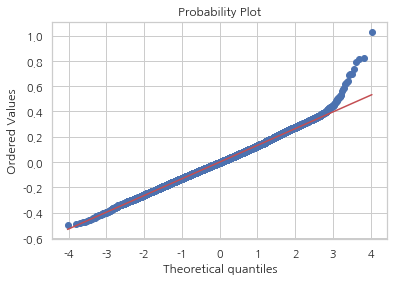

In [12]:
# outlier remove result 
sp.stats.probplot(result.resid, plot=plt)
plt.show()

In [13]:
test = sms.omni_normtest(result.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       : 382.007
P-value     :  0.000


# Partial Regression Plot
Let's visualize the influence of a single independent variable.

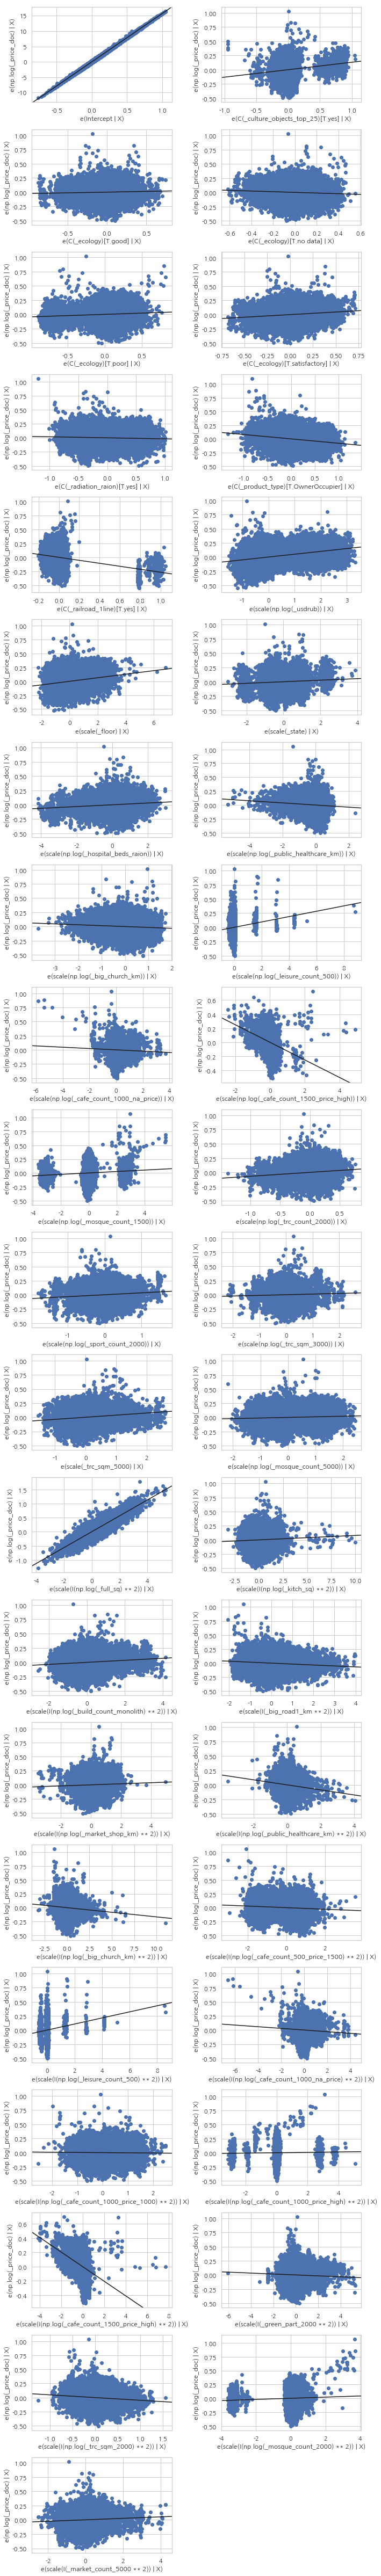

In [14]:
fig = plt.figure(figsize=(10,70))
sm.graphics.plot_partregress_grid(result, fig=fig)
fig.suptitle("")
plt.show()

# 6. Cross Validation

In [15]:
dm = dmatrix(" + ".join(sms_vars) + ' + np.log(_price_doc)', df_train_macro_with_outliers, return_type="dataframe")
X = dm[dm.columns.drop(['np.log(_price_doc)'])]
y = dm['np.log(_price_doc)']
cv = cv = KFold(n_splits=1000, shuffle=True, random_state=0)
r2s = cross_val_score(SMWrapper(sm.OLS), X, y, scoring='r2', cv=cv)
r2s.mean()

0.36796494715302286

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
         1.,  2.,  0.,  2.,  1.,  3.,  3.,  1.,  1.,  2.,  3.,  2.,  3.,
         1.,  3.,  4.,  8.,  8.,  9.,  3.,  8., 12., 13.,  7.,  5., 11.,
         6., 19., 15., 14., 12., 16., 20., 30., 17., 21., 24., 24., 18.,
        27., 45., 23., 29., 26., 24., 27., 33., 30., 29., 25., 32., 21.,
        21., 18., 27., 22., 16., 22., 21., 19., 14., 20., 10., 17., 12.,
         2.,  7.,  3.,  3.,  8.,  5.,  1.,  1.,  1.]),
 array([-0.67188319, -0.65672897, -0.64157475, -0.62642053, -0.61126631,
        -0.59611209, -0.58095787, -0.56580365, -0.55064943, -0.53549521,
        -0.52034099, -0.50518677, -0.49003255, -0.47487833, -0.4597241 ,
        -0.44456988, -0.42941566, -0.41426144, -0.39910722, -0.383953  ,
        -0.36879878, -0.35364456, -0.33849034, -0.32333612, -0.3081819 ,
        -0.29302768, -0.27787346, -0.26271923, -0.24756501, -0.232410

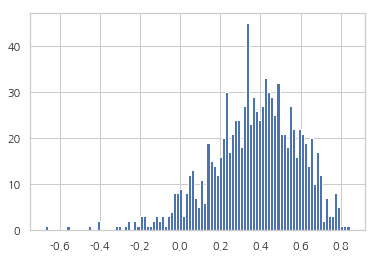

In [16]:
plt.hist(r2s, bins=100)

In [17]:
y_pred = np.exp(result.predict(df_test_macro))
y_pred = y_pred.to_frame('price_doc')
y_pred.to_csv('./data/stats_models_{}.csv'.format(datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')), header=True, index=True)

## Score

0.40580